# Facebook Prophet - Forecasting Stock Prices

###  Index: 
- **Importing Data:**
    - [Importing the Shifted Dataset](#Shifting)
- **Data Preprocessing:** 
    - [Preparing the Data for Modeling](#Prep)
- **Supervised Machine Learning Model:**
    - [Facebook Prophet Models](#FBProphet)
    - [Visualizing Results](#FBProphetVIS)


## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from fbprophet import Prophet

import sys
sys.path.append('..')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

-----

## Company Name

**Company Options:**

- Apple, Inc. - `Apple`
- Facebook, Inc. -`Facebook`
- Google LLC - `Google`
- JPMorgan Chase & Co. - `JPMorgan`
- The Goldman Sachs Group, Inc. - `GoldmanSachs`
- Moody's Corporation - `Moodys`
- The International Business Machines Corporation (IBM) - `IBM`
- Twitter Inc. - `Twitter`
- BlackRock, Inc. - `BlackRock`
- Microsoft Corporation - `Micrisoft`

In [41]:
company_name = 'Google'

<a class="anchor" id="Shifting"></a>

# Importing the Data

### Creating a Custom Function to Import the Data:
- The function will read and import the shifted dataset from a CSV.
- Additionally, the Values from the Date column will be converted into time.
- Then, the Date will be place as the Index to perform a sequential supervised machine learning model.
- Finally, the index (Date) will be sorted in ascending order starting with the date of the company's Initial Price Offering (IPO) to the most recent date. 

In [42]:
def df_shift_importer(company_name):
    """ 
    Returns a shifted dataframe from a CSV according to the company.
    
    Parameter
    ----------
    company_name : var or str
        Passes the variable assigned to the company's name.
    """
    company_name=company_name
    # Reads the Shifted dataframe from a CSV.
    df_shift = pd.read_csv(f'data/modeling_data/{company_name}_Shifted_DF.csv')
    # Converts the date into time.
    df_shift['Date'] = pd.to_datetime(df_shift.Date)
    # Places the date as the index.
    df_shift.set_index('Date', inplace=True)
    # Sorts the index into ascending order.
    df_shift.sort_index(inplace=True, ascending=True)
    return df_shift

In [43]:
df_shift = df_shift_importer(company_name)
df_shift.head(3)

,Open,High,Low,Close,Volume,Ex_Dividend,Split_Ratio,Adj_Open,Adj_High,Adj_Low,...,Low_Long_EMA,Close_Long_EMA,Volume_Long_EMA,Ex_Dividend_Long_EMA,Split_Ratio_Long_EMA,Adj_Open_Long_EMA,Adj_High_Long_EMA,Adj_Low_Long_EMA,Adj_Close_Long_EMA,Adj_Volume_Long_EMA
Date,,,,,,,,,,,,,,,,,,,,,
2004-12-20,176.76,180.50,176.55,180.08,14757600.0,0.0,1.0,88.653665,90.529456,88.548340,...,150.523297,153.696417,2.361479e+07,0.0,1.0,76.962873,78.701800,75.494693,77.086166,2.361479e+07
2004-12-21,182.00,188.46,181.87,185.02,19649300.0,0.0,1.0,91.281778,94.521780,91.216577,...,151.252290,154.424872,2.352257e+07,0.0,1.0,77.295871,79.069706,75.860319,77.451521,2.352257e+07
2004-12-22,186.28,187.88,183.40,183.75,11021500.0,0.0,1.0,93.428405,94.230882,91.983946,...,151.999911,155.106852,2.323185e+07,0.0,1.0,77.671046,79.422292,76.235287,77.793567,2.323185e+07


------
<a class="anchor" id="Prep"></a>
# Preparing the Data:

- As specified by Facebook's Prophet Documentation, the following function will change the name for the date and label accordingly. 
- Additionally, the function accepts a date, which will be as the commencement of the new dataframe.

In [44]:
def prophet_processor(dataframe, start_date):
    """
    Returns a processed dataframe as specified by Facebook's Prophet documentation.
    
    Parameters
    ----------
    
    dataframe : var
        Passes the variable assigned to a dataframe.
    
    start_date : str
        Passes a filter using the passed date as the starting point for the new dataframe. 
        Format string as: 'YYYY-MM-DD'
    
    """
    # Copying and filtering the dataframe.
    temp_df = dataframe[f'{start_date}':].copy()
    # Placing the date as a column rather than index. 
    temp_df.reset_index(inplace=True)
    # Renaming the columns as specified by Facebook Prophet's documentation.
    temp_df.rename(columns={'Date':'ds', 'Adj_Close':'y'}, inplace=True)
    return temp_df

### Processing the Data for Modeling:

In [45]:
prophet_df = prophet_processor(df_shift, '2014-01-02')
prophet_df.head(3)

,ds,Open,High,Low,Close,Volume,Ex_Dividend,Split_Ratio,Adj_Open,Adj_High,...,Low_Long_EMA,Close_Long_EMA,Volume_Long_EMA,Ex_Dividend_Long_EMA,Split_Ratio_Long_EMA,Adj_Open_Long_EMA,Adj_High_Long_EMA,Adj_Low_Long_EMA,Adj_Close_Long_EMA,Adj_Volume_Long_EMA
0,2014-01-02,1112.24,1121.00,1106.26,1120.71,2713000.0,0.0,1.0,557.842005,562.235567,...,998.455994,1005.530951,3.468605e+06,0.0,1.0,503.773187,507.358917,500.773838,504.322270,3.468605e+06
1,2014-01-03,1115.46,1117.75,1108.26,1113.12,3639100.0,0.0,1.0,559.456990,560.605536,...,1001.009575,1008.033022,3.472570e+06,0.0,1.0,505.068159,508.597210,502.054582,505.577179,3.472570e+06
2,2014-01-06,1115.00,1116.93,1104.93,1105.00,3330000.0,0.0,1.0,559.226278,560.194266,...,1003.426329,1010.288068,3.469254e+06,0.0,1.0,506.327650,509.797142,503.266701,506.708193,3.469254e+06


### Reducing Bias: Dropping all Values Pertaining to the Closing Price
- Dropping the all columns dealing with the closing price so the model won't pick up on the signal; therefore, reducing bias.

In [46]:
prophet_df.drop(['Close_Short_SMA',
                 'Adj_Close_Short_SMA',
                 'Close_Mid_SMA',
                 'Adj_Close_Mid_SMA',
                 'Close_Long_SMA',
                 'Adj_Close_Long_SMA',
                 'Close_Short_EMA',
                 'Adj_Close_Short_EMA',
                 'Close_Mid_EMA',
                 'Adj_Close_Mid_EMA',
                 'Close_Long_EMA',
                 'Adj_Close_Long_EMA',],
                axis=1, inplace = True)

-------
<a class="anchor" id="FBProphet"></a>



# Supervised Machine Learning with Facebook Prophet:

#### Facebook Prophet Intro:
Prophet is an open source library published by Facebook to assist organizations to efficiently allocate resources in order to set goal-oriented business strategies by measuring performances relative to a baseline given by the model. 

- **Prophet:** an additive regression model that provides the ability to make time series forecasting using decomposable trends, holidays, and seasonal models. 

Prophet automatically detects changes in trends by selecting changepoints from the data. Additionally, the models possess the ability to intuitively adjust parameters with basic understanding of **Autoregressive Integrated Moving Average (ARIMA)** Models.


#### Parameters for Trends:
| Parameter for Trends | Specification |
|------|------|
| `growth` | Model: linear or logistic trend. |
| `changepoints`	| Passes a list of dates for the changepoints |
| `n_changepoints` | Number of `changepoints` to be automatically executed. |
| `changepoint_prior_scale`| Changes flexibility for selecting automatic `changepoint` |


#### Seasonal and Holiday Parameters:

| Parameters for Seasons and Holidays| Specification |
|------|------|
| `yearly_seasonality` | Passes yearly seasonality|
| `weekly_seasonality`| Passes weekly seasonality|
| `daily_seasonality` | Passes daily seasonality |
| `holidays` | Passes a dataframe containing holiday name and date |
| `seasonality_prior_scale` | Changes strength of seasonality model |
| `holiday_prior_scale` | Changes strength of holiday model|



------

## Modeling with Prophet

- Training a Linear Regression Model using a yearly seasonal trend starting on January 2014.
    - After training a few models, I have noticed a yearly trends works better than a daily trend.
- Forecasting 5 months into the future.

In [47]:
# Parameters: Linear Regression Model with a yearly seasonal trend
m = Prophet(growth='linear', yearly_seasonality = True)
# Training the Model
m.fit(prophet_df)
# Forecasting 150 Days into the Future
future = m.make_future_dataframe(periods=150)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/adamdelreal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Comparing the Recent Price with the Predicted Price:

|Date | Current Price | Predicted |
|------|------|------|
| 2018/07/28| 190.98 | 192.88 

### Evaluation

The model performs fairly well considering how intricate the task at hand is. Forecast the stock market with a relatively small margin of error of $1.90 more than the actual price is not too shabby!

In [48]:
forecast[forecast['ds'] > '2018-07-26'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
1186,2018-07-27,1218.067284,1179.059612,1262.806303
1187,2018-07-28,1212.580666,1168.663259,1258.421490
1188,2018-07-29,1213.532613,1171.396978,1255.223723
1189,2018-07-30,1220.674074,1181.014649,1264.516818
1190,2018-07-31,1221.035278,1179.385913,1267.518876


<a class="anchor" id="FBProphetVIS"></a>
### Visualizing the Results:

#### Evaluation: 
- The illustration below demonstrates the model is relatively overfit. An overfit model generally takes the form of the idiosyncrasies in the data too well, as we can see in the blue line labeled as `yhat`.
    - **Overfitting** is a modeling error that occurs when a function is excessively closely fitting to the data points in the training set. 
    
    - **Idiosyncratic Error** describes the error in sequential data that changes over time and across units; this can be perceived as trends.


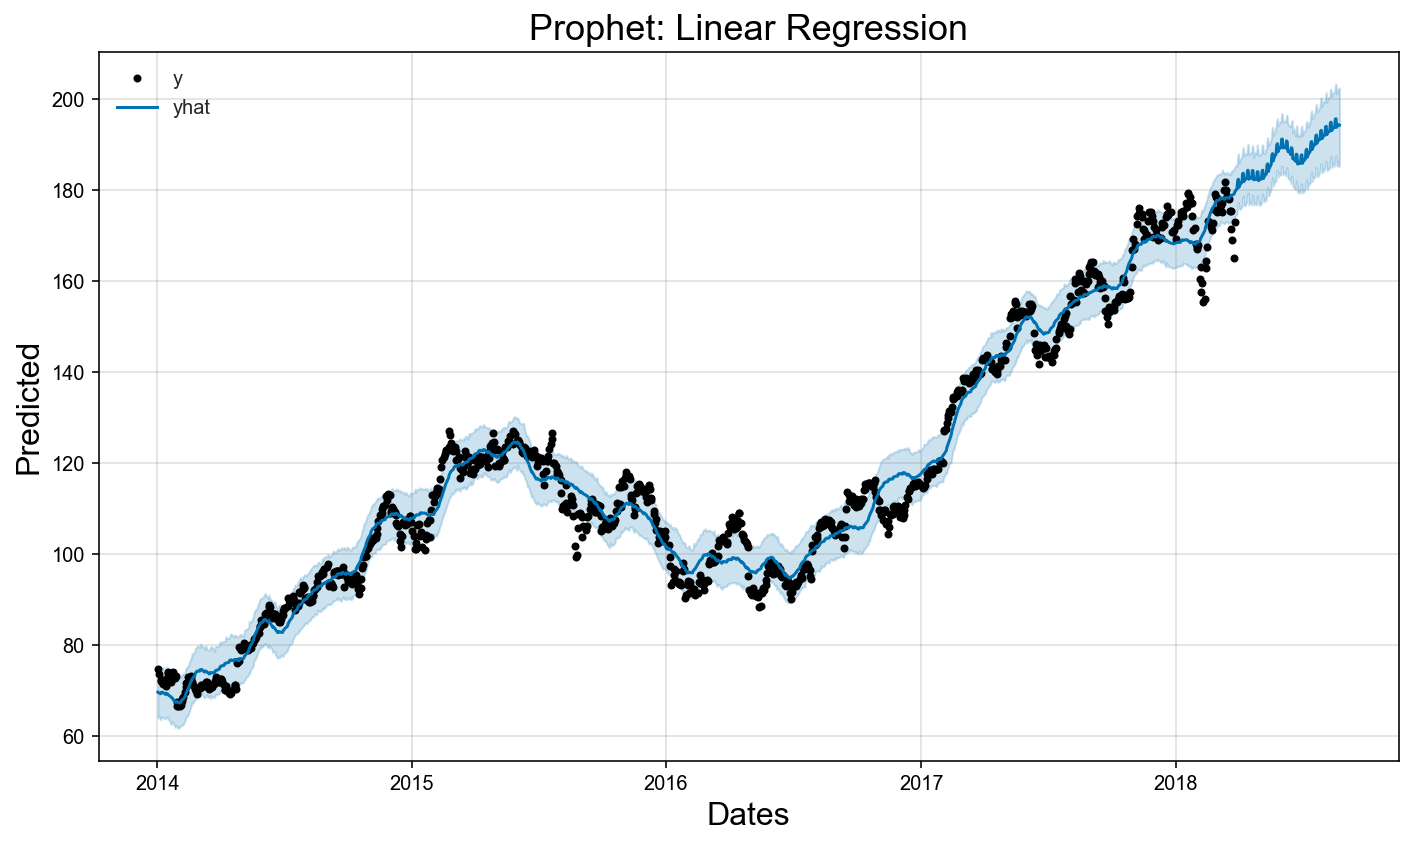

In [10]:
# Plotting the results.
fig = m.plot(forecast)
# Setting up a dark background.
sns.set_style("darkgrid")
# Adding the Title, X & Y Labels, and legend.
plt.title('Prophet: Linear Regression', fontsize=18)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend()
plt.tight_layout()

### Visualizing the Results with Change Points:

It seems the model picks up changes in trends in peaks and valleys of the price fluctuation. Overall, 11 change points were picked up by the model. Change points can be adjusted to overcome *overfitting* and *underfitting*. The fit of the model becomes more flexible as the number of change points increases. An example of this is demonstrated in the second Prophet model as you continue to browse through this notebook.

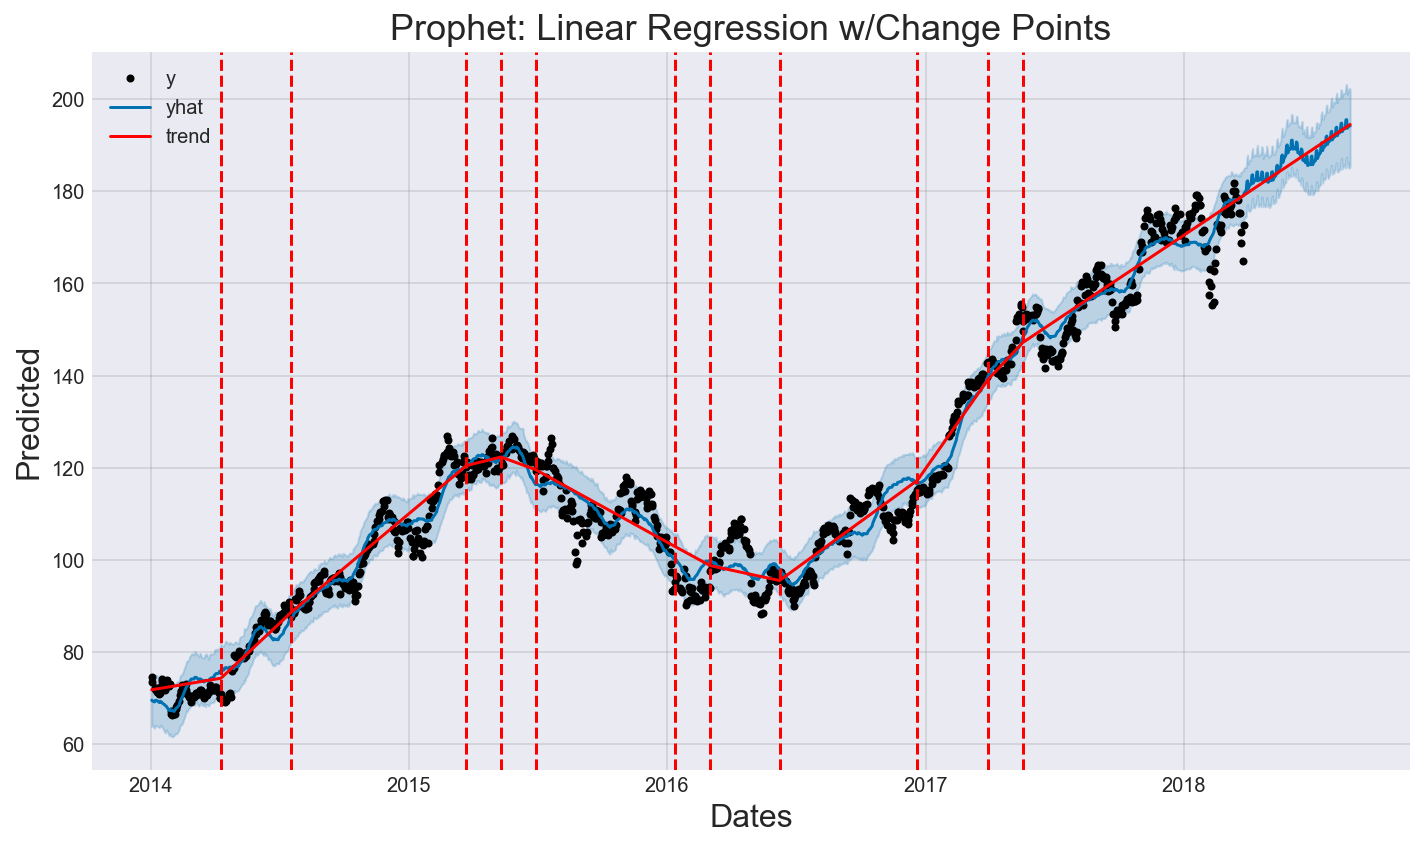

In [11]:
from fbprophet.plot import add_changepoints_to_plot
# Plotting the Results.
fig = m.plot(forecast)
# Plotting the Change Points
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Setting up a dark background.
sns.set_style("darkgrid")
# Adding the Title, X & Y Labels, and legend.
plt.title('Prophet: Linear Regression w/Change Points', fontsize=18)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend()
plt.tight_layout()

### Inspecting the Components (Trends):

#### Description of Each Trend:
- The first graph displays the **yearly trend.**
- The second displays the **monthly trend.**
- The third displays the **weekly trend.**
- The fourth displays the another **yearly trend.**
- The fifth displays a trend on the **first of every month.**
- The sixth, and final graph, shows a **scaled trend.**

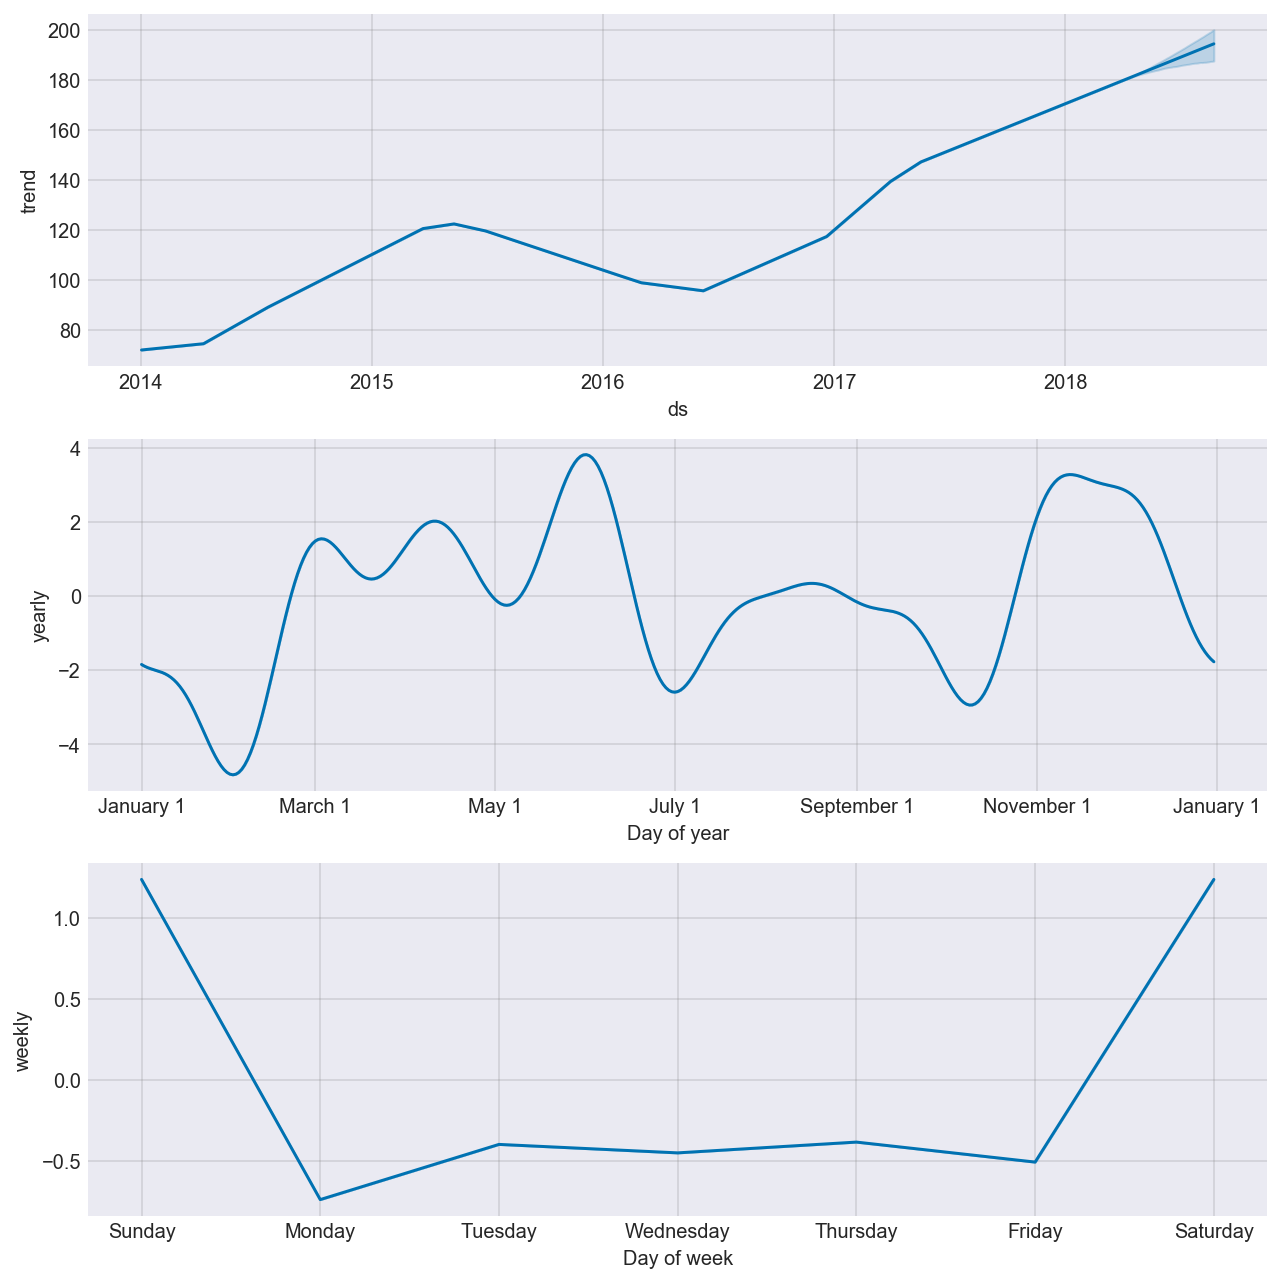

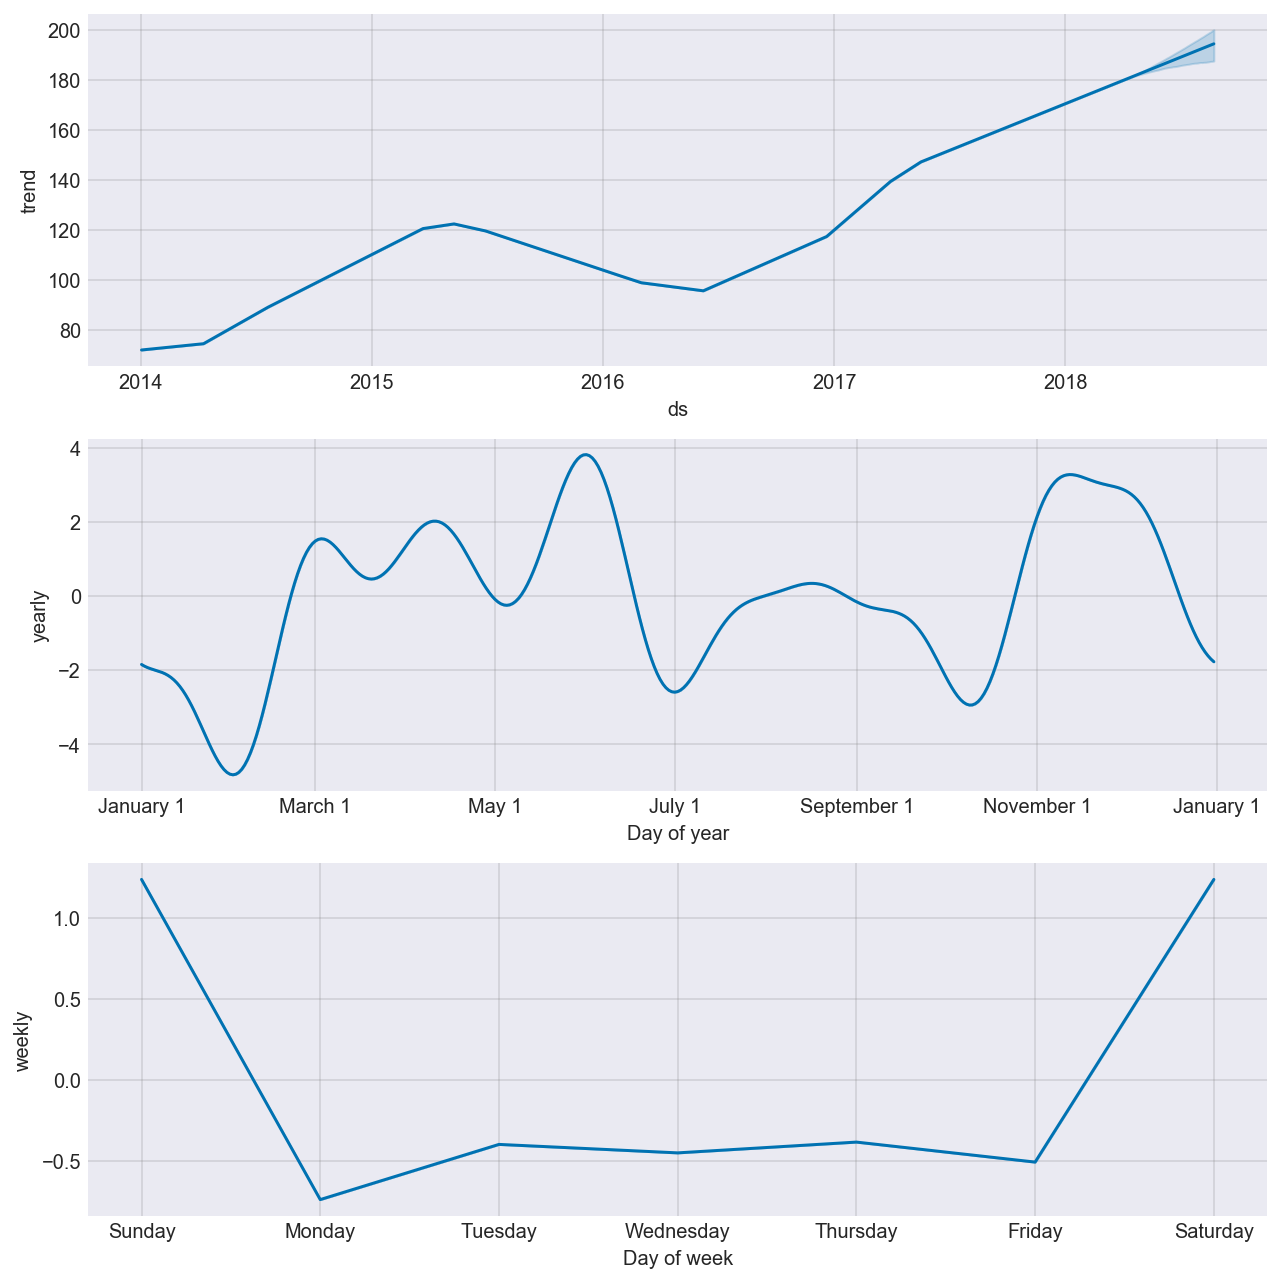

In [12]:
m.plot_components(forecast)

------

# Prophet Model: Attempting to Reduce Overfit

In this example, the model will be tuned to increase flexibility in the changing points, or trends, to reduce any overfitting. 

In [13]:
# Parameters: Linear Regression Model with a yearly seasonal trend
m = Prophet(growth='linear', yearly_seasonality = True, n_changepoints=150, changepoint_prior_scale=.07)
# Training the Model
m.fit(prophet_df)
# Forecasting 150 Days into the Future
future = m.make_future_dataframe(periods=150)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/adamdelreal/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


### Comparing the Recent Price with the Predicted Price:

|Date | Current Price | Predicted |
|------|------|------|
| 2018/07/28| 190.98 | 189.64 

### Evaluation

This model also performs fairly well. The error was about relatively small margin of error of $1.34 less then the actual price is also not too bad.

In [14]:
forecast[forecast['ds'] > '2018-07-25'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
1184,2018-07-26,189.441608,182.923816,195.799371
1185,2018-07-27,189.474425,182.943136,196.094423
1186,2018-07-28,190.259767,183.573370,196.330156
1187,2018-07-29,190.399523,183.573414,196.607314
1188,2018-07-30,189.648050,183.640765,195.815142


### Visualizing the Results:

#### Evaluation: 
- The illustration below demonstrates the model is still relatively overfit. However, it was the most balanced out of the models tested. 

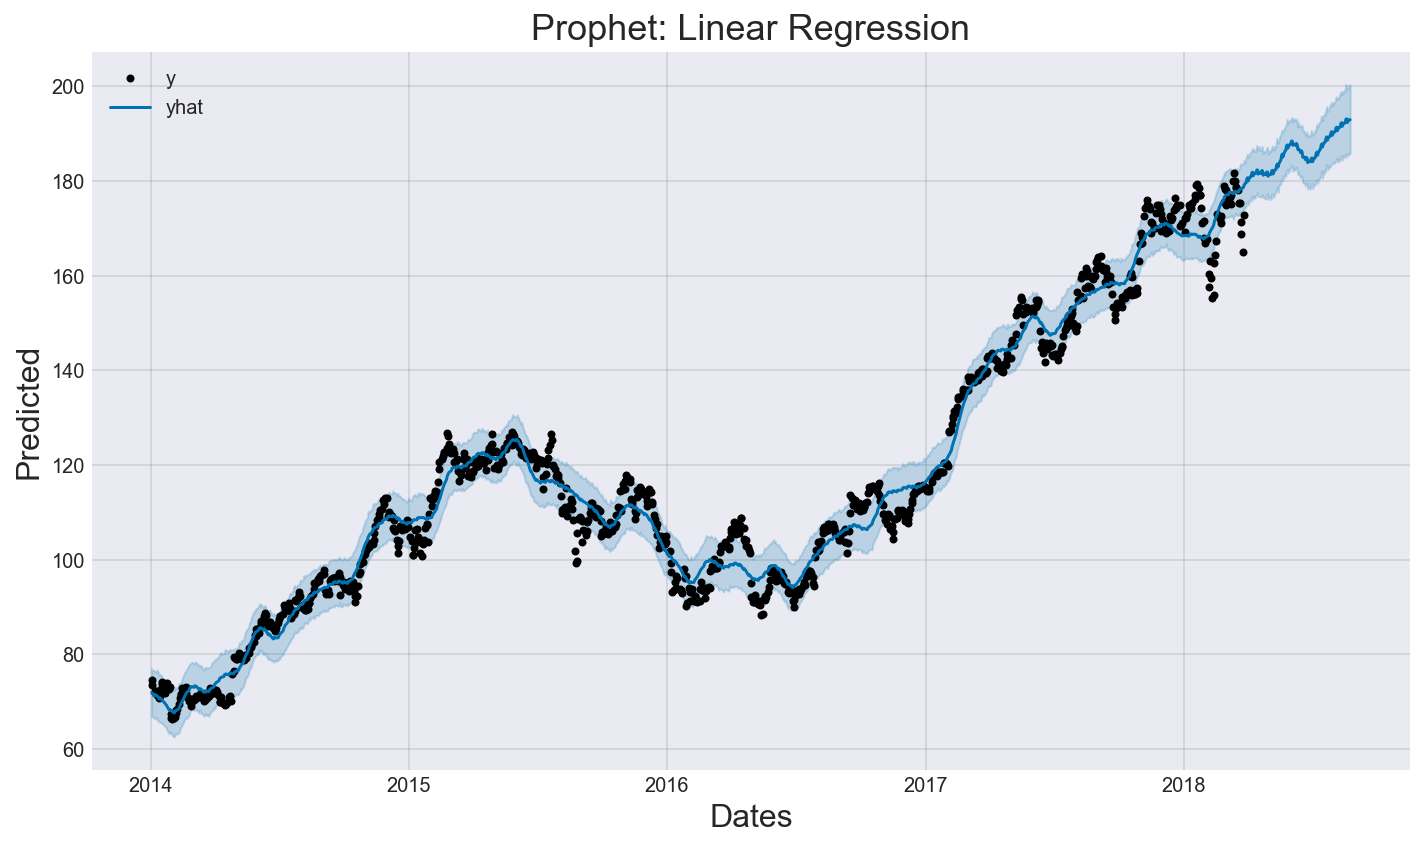

In [15]:
# Plotting the results.
fig = m.plot(forecast)
# Setting up a dark background.
sns.set_style("darkgrid")
# Adding the Title, X & Y Labels, and legend.
plt.title('Prophet: Linear Regression', fontsize=18)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend()
plt.tight_layout()

### Visualizing the Results with Change Points:

It seems the model picks up more changes in the fluctuation of price. Adding more change points, but still fairly overfit in my opinion.

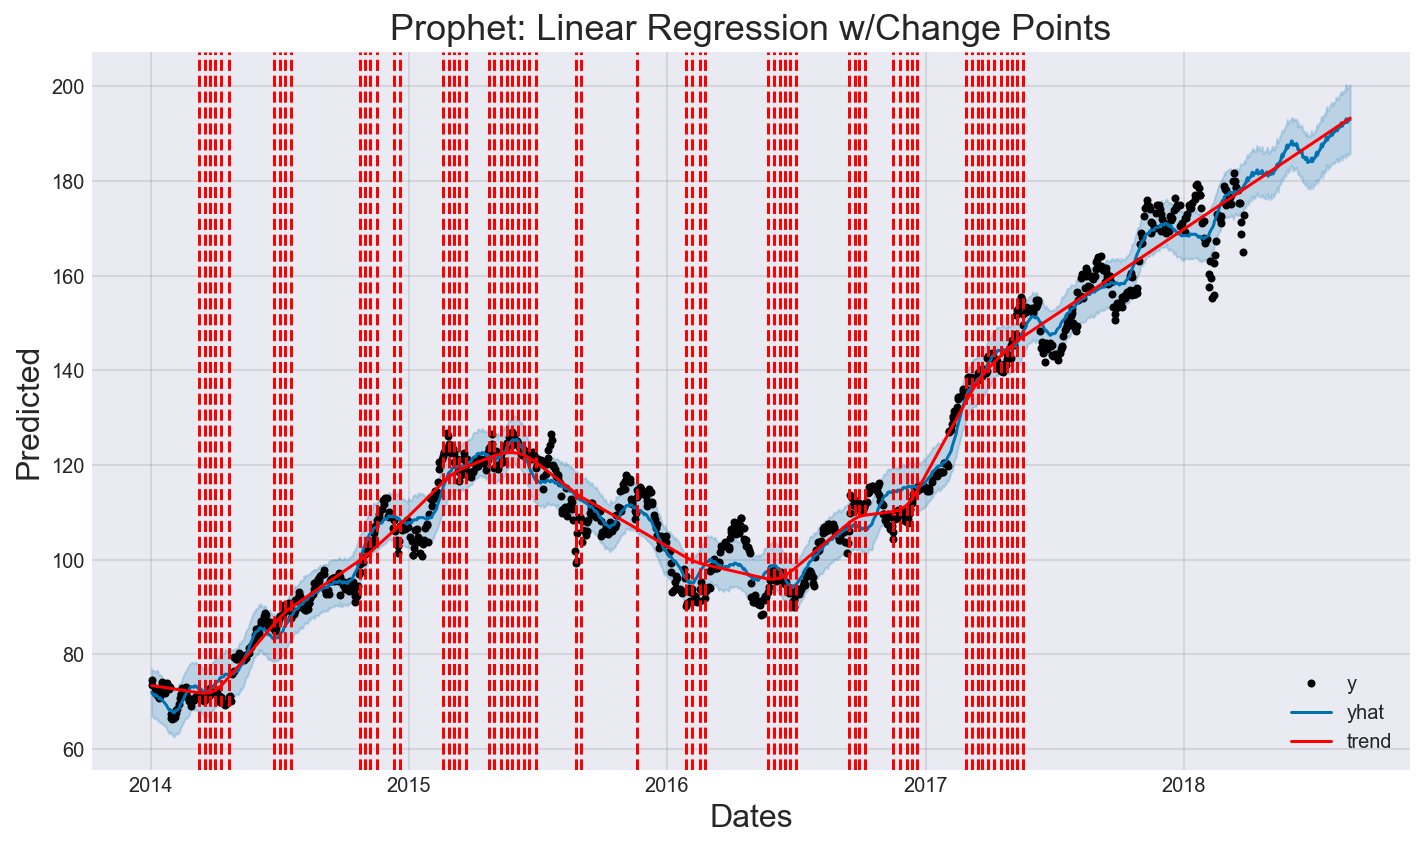

In [16]:
# Plotting the Results.
fig = m.plot(forecast)
# Plotting the Change Points
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Setting up a dark background.
sns.set_style("darkgrid")
# Adding the Title, X & Y Labels, and legend.
plt.title('Prophet: Linear Regression w/Change Points', fontsize=18)
plt.xlabel('Dates', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.legend()
plt.tight_layout()

### Inspecting the Components (Trends):

#### Description of Each Trend:
- The first graph displays the **yearly trend.**
- The second displays the **monthly trend.**
- The third displays the **weekly trend.**
- The fourth displays the another **yearly trend.**
- The fifth displays a trend on the **first of every month.**
- The sixth, and final graph, shows a **scaled trend.**

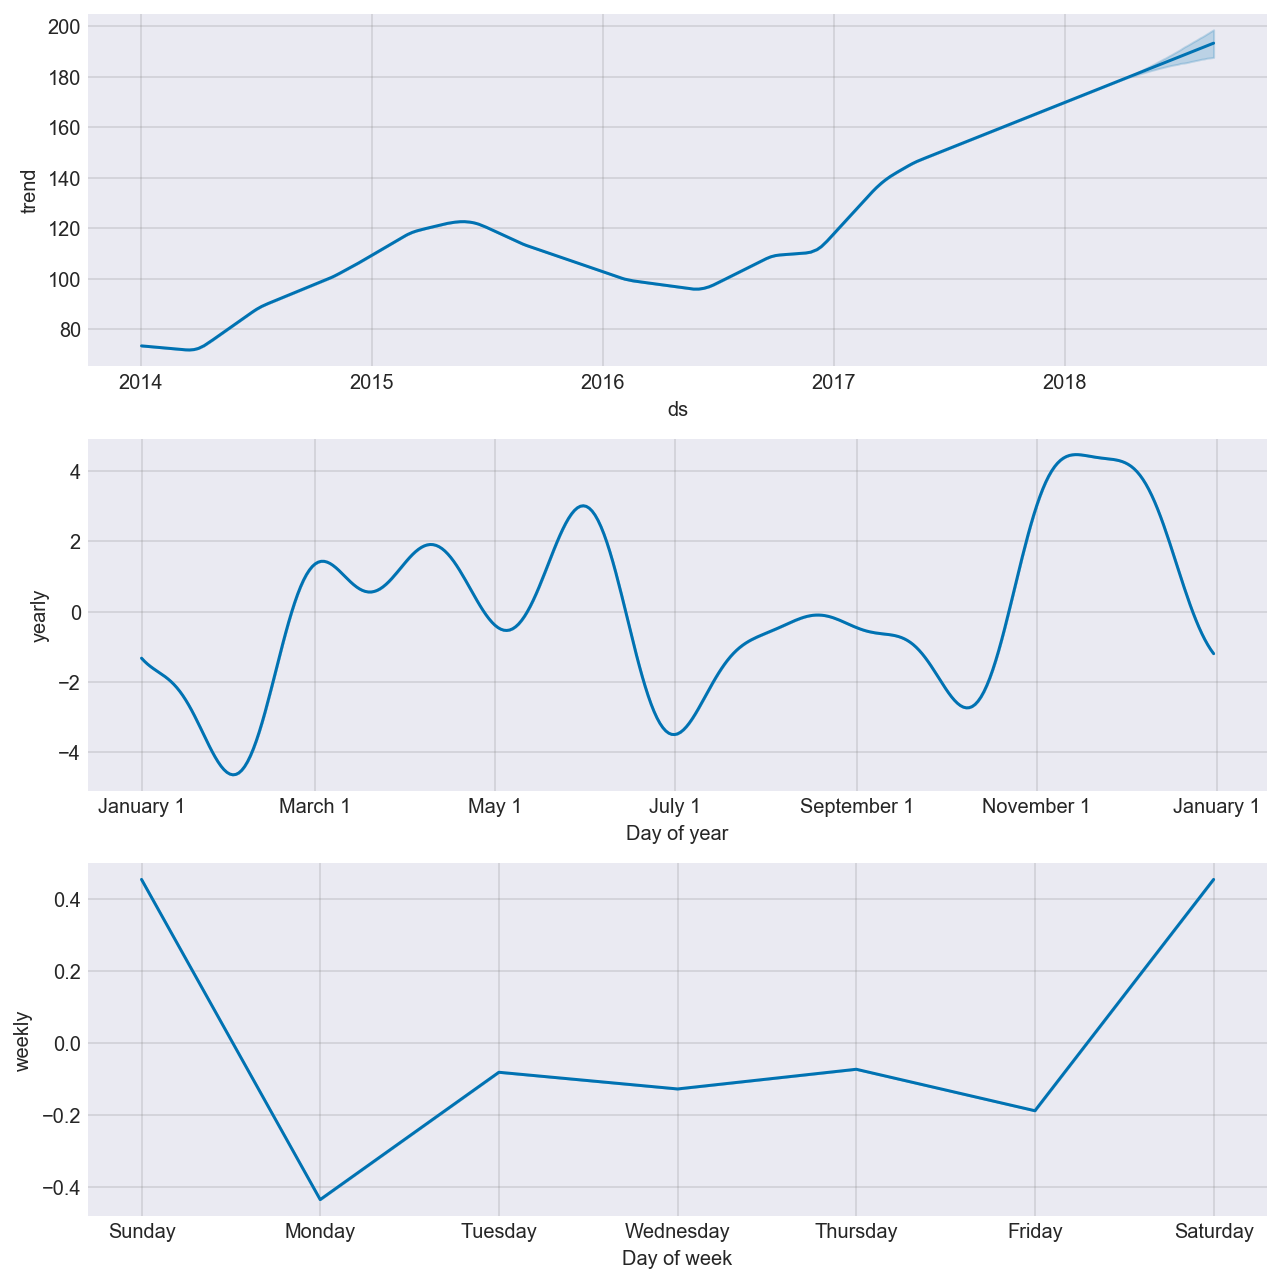

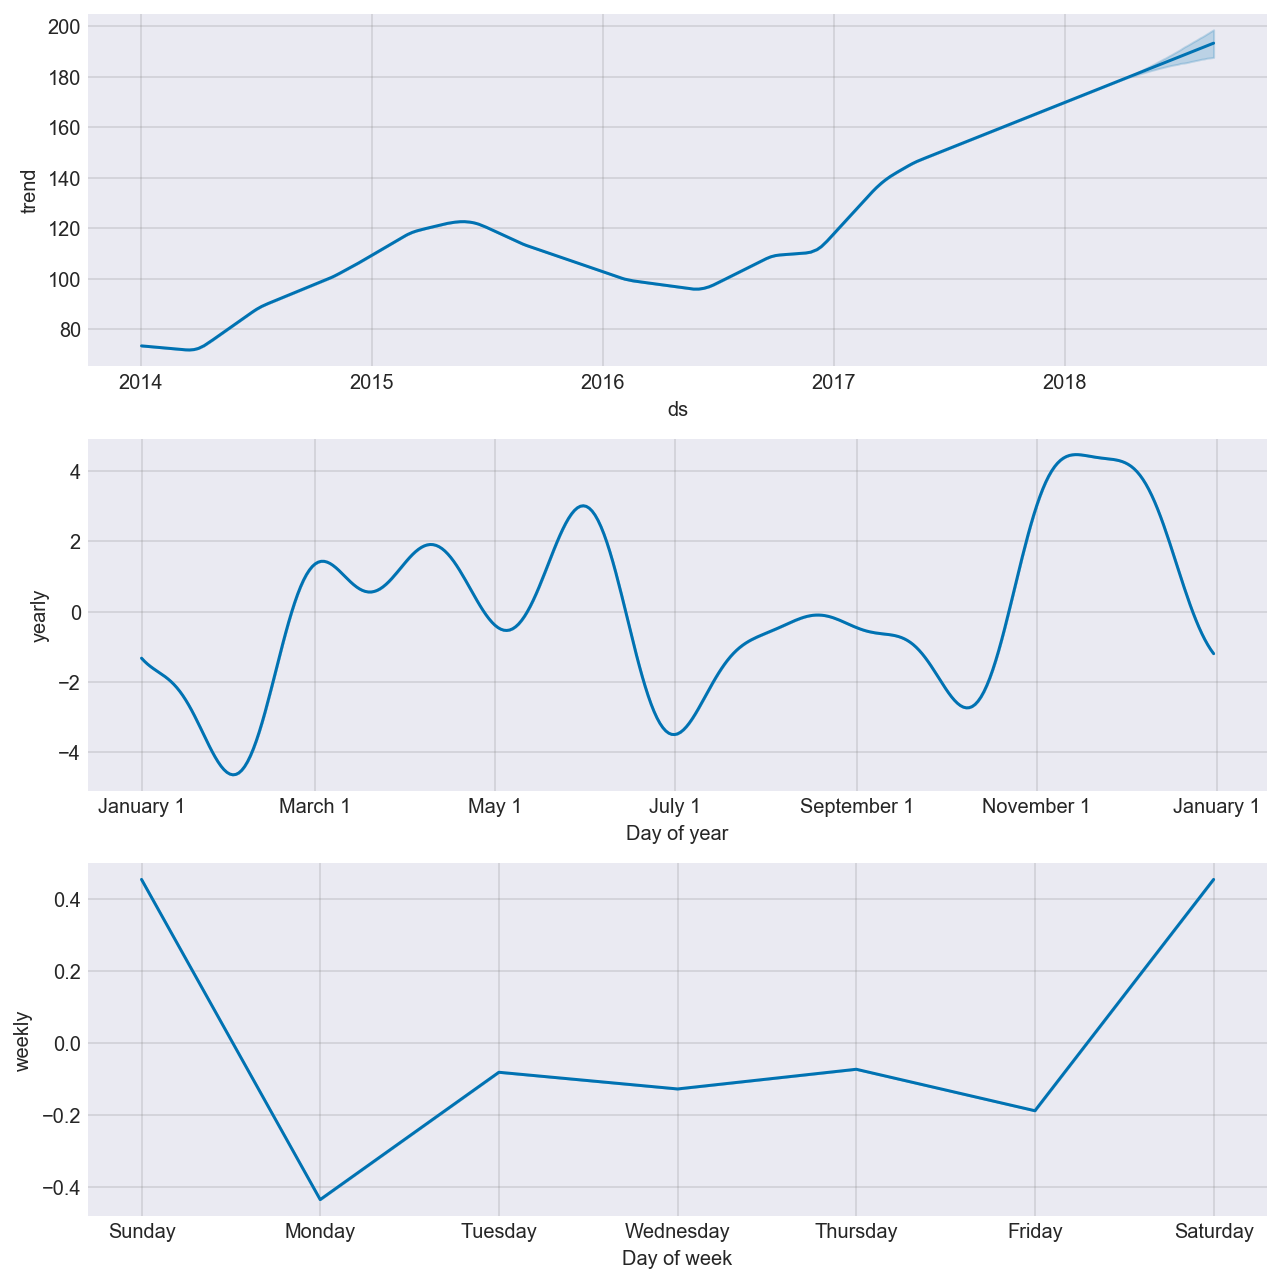

In [17]:
m.plot_components(forecast)